# Data exploration
Use this notebook to graph the employee attrition by department and position.

We start by retrieving the mapping of department code and position code to their name from a Db2 database.

We then read the attrition data into a Pandas dataframe.<br/>
If the dataset was larger, we could use database tables and queries to get the result directly.<br/>
This would have the additional benefit of pushing the processing closer to the data, making it more efficient.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ibm_db
import ibm_db_dbi

## Department and position names
The CSV file we are using only contains codes. <br/>
To make the result easier to understand, we get the names from a Db2 database

In [2]:
credentials = {
    'username': 'cpdemo',
    'password': """**************""",
    'sg_service_url': 'https://sgmanager.ng.bluemix.net',
    'database': 'BLUDB',
    'host': 'db2w-ovqfeqq.us-south.db2w.cloud.ibm.com',
    'port': '50001',
    'url': 'https://undefined'
}

In [3]:
dsn = (
    "DRIVER={{IBM DB2 ODBC DRIVER}};"
    "DATABASE={0};"
    "HOSTNAME={1};"
    "PORT={2};"
    "PROTOCOL=TCPIP;"
    "SECURITY=ssl;"
    "UID={3};"
    "PWD={4};").format(credentials['database'], credentials['host'],
                       credentials['port'], credentials['username'],
                       credentials['password'])

conn = ibm_db.connect(dsn, "", "")
pconn = ibm_db_dbi.Connection(conn)

In [4]:
sql="""
SELECT DEPARTMENT_CODE, DEPARTMENT_EN as DEPARTMENT 
FROM EMPLOYEE.DEPARTMENT_LOOKUP
"""
dept_pd=pd.read_sql(sql,pconn)
dept_pd.head(5)

DEPARTMENT_CODE                   DEPARTMENT
0              200                    Corporate
1              320                      Finance
2              330                    Marketing
3              350                  Procurement
4              360  Production and Distribution

In [5]:
sql="""
SELECT POSITION_CODE, POSITION_EN as POSITION
FROM EMPLOYEE.POSITION_LOOKUP
;
"""
posi_pd=pd.read_sql(sql,pconn)
posi_pd.head(5)

POSITION_CODE                           POSITION
0           1500  Vice-President of Human Resources
1           1900                    Finance Manager
2           2100                     Budget Analyst
3           2300                 Accounting Manager
4           2600                   Accounting Clerk

## Now we get the content of the CSV file
Note that the code in the next cell is generated through the data tab `insert to code`<br/>
This additional ease of use is a great time saver. 

In [7]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_830e2f37a987425c8dcf9c38d0821bd8 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_830e2f37a987425c8dcf9c38d0821bd8 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_830e2f37a987425c8dcf9c38d0821bd8 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='********************************',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_830e2f37a987425c8dcf9c38d0821bd8)

body = client_830e2f37a987425c8dcf9c38d0821bd8.get_object(Bucket='********************************',Key='modeling_records')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


POSITION_CODE  DEPARTMENT_CODE  DAYS_WITH_COMPANY  COMMUTE_TIME  \
0           1200              200               1825            29   
1           1200              200               2615             0   
2           1300              320               1609            30   
3           1300              320               2035            13   
4           1400              380               1885            31   

   AGE_BEGIN_PERIOD  GENDER_CODE  ATTRITION  PERIOD_TOTAL_DAYS  \
0                55            0          0                330   
1                49            0          0                180   
2                44            1          0                330   
3                45            0          0                330   
4                44            0          0                330   

   STARTING_SALARY  ENDING_SALARY  ...  VACATION_DAYS_TAKEN  SICK_DAYS_TAKEN  \
0        159230.77      161538.46  ...                   28             10.5   
1        181153.85      183846.15  ...                   15              4.0   
2        129692.31      132923.08  ...                   20             15.0   
3        146769.23      150461.54  ...                   28              8.0   
4        146769.23      150461.54  ...                   26             11.5   

   PROMOTIONS  NB_MANAGERS  DAYS_IN_POSITION  DAYS_SINCE_LAST_RAISE  \
0           0            1              1825                      0   
1           0            1              2615                     60   
2           0            1              1609                    150   
3           0            1              2035                    210   
4           0            1              1885                     60   

   RANKING_CODE  OVERTIME  DBLOVERTIME  TRAVEL  
0             3       0.0          0.0       0  
1             3       0.0          0.0       0  
2             3       0.0          0.0       0  
3             3       0.0          0.0       0  
4             3       0.0          0.0       0  

[5 rows x 23 columns]

## Get the result by department code
We have to consider that each department has a different number of employees so only displaying<br/> 
the number of people that left by department would be misleading when comparing departments.

The solution is to also display the total number of employee by department.

We also include the percentage of attrition since it is roughly in the same scale.<br/>
This way, we can more easily find the worst departments while still having the absolute number of employees and attrition.

In [8]:
# Aggregate for attrition
group_pd = df_data_1[['DEPARTMENT_CODE','ATTRITION']].groupby(['DEPARTMENT_CODE']).agg(['sum', 'count']).reset_index()
# Set the index to the department code so we can join
group_pd.index = group_pd['DEPARTMENT_CODE'].values
# Flatten the result
group_pd.columns = ['_'.join(col).strip() for col in group_pd.columns.values]
# Remove the rows with no attrition
group_pd = group_pd[group_pd['ATTRITION_sum'] > 0]
# Calculate percentage of attrition. This way, we can compare departments
group_pd['PERCENT'] = 100 * group_pd['ATTRITION_sum'] / group_pd['ATTRITION_count']
group_pd.head(5)

DEPARTMENT_CODE_  ATTRITION_sum  ATTRITION_count    PERCENT
300               300              5               15  33.333333
320               320             10               33  30.303030
330               330              1               10  10.000000
340               340              7               22  31.818182
350               350              4               10  40.000000

In [9]:
# Join with department names
graph_pd = dept_pd.join(group_pd, on="DEPARTMENT_CODE",rsuffix="_b")[
      ['DEPARTMENT','ATTRITION_sum', 'ATTRITION_count', 'PERCENT']].dropna()
graph_pd.index = graph_pd['DEPARTMENT'].values
graph_pd

DEPARTMENT  \
Finance                                                          Finance   
Marketing                                                      Marketing   
Procurement                                                  Procurement   
Production and Distribution                  Production and Distribution   
Information Services and Technology  Information Services and Technology   
Human Resources                                          Human Resources   
Customer Service                                        Customer Service   
Sales                                                              Sales   
Sales (Corporate)                                      Sales (Corporate)   

                                     ATTRITION_sum  ATTRITION_count    PERCENT  
Finance                                       10.0             33.0  30.303030  
Marketing                                      1.0             10.0  10.000000  
Procurement                                    4.0             10.0  40.000000  
Production and Distribution                   16.0             35.0  45.714286  
Information Services and Technology            7.0             18.0  38.888889  
Human Resources                                5.0             15.0  33.333333  
Customer Service                              10.0             22.0  45.454545  
Sales                                         25.0             70.0  35.714286  
Sales (Corporate)                              7.0             22.0  31.818182

<AxesSubplot:xlabel='Department', ylabel='Attrition'>

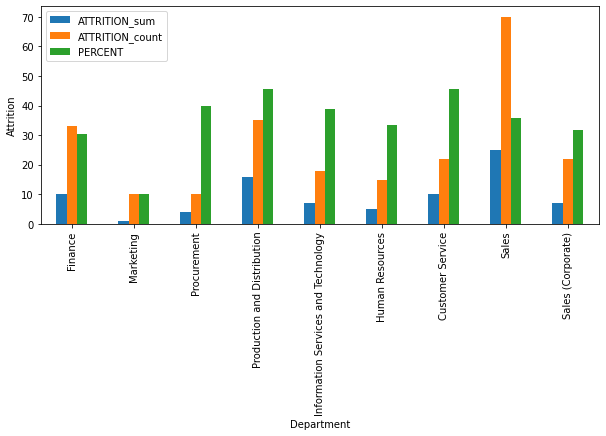

In [10]:
# ATTRITION_count: number of people in this department
#ATTRITION_sum: number of people that left
graph_pd.plot.bar(xlabel="Department", ylabel="Attrition", figsize=(10,4))

## Get the result by position code
We have to consider that each position has a different number of employees so only displaying<br/>
the number of people that left by position would be misleading when comparing positions.

The solution is to also display the total number of employee by position.

We also include the percentage of attrition since it is roughly in the same scale.<br/>
This way, we can more easily find the worst positions while still having the absolute number of employees and attrition.

In [11]:
# Aggregate for attrition
group2_pd = df_data_1[['POSITION_CODE','ATTRITION']].groupby(['POSITION_CODE']).agg(['sum', 'count']).reset_index()
# Set the index to the department code so we can join
group2_pd.index = group2_pd['POSITION_CODE'].values
# Flatten the result
group2_pd.columns = ['_'.join(col).strip() for col in group2_pd.columns.values]
# Remove the rows with no attrition
group2_pd = group2_pd[group2_pd['ATTRITION_sum'] > 0]
# Calculate percentage of attrition. This way, we can compare departments
group2_pd['PERCENT'] = 100 * group2_pd['ATTRITION_sum'] / group2_pd['ATTRITION_count']
group2_pd.head(5)

POSITION_CODE_  ATTRITION_sum  ATTRITION_count    PERCENT
2000            2000              1                3  33.333333
2200            2200              3                7  42.857143
2300            2300              1                2  50.000000
2400            2400              2                5  40.000000
2500            2500              1                4  25.000000

In [12]:
# Join with position names
graph2_pd = posi_pd.join(group2_pd, on="POSITION_CODE",rsuffix="_b")[
    ['POSITION_CODE','POSITION','ATTRITION_sum', 'ATTRITION_count','PERCENT']].dropna()
graph2_pd.index = graph2_pd['POSITION'].values
graph2_pd.head(5)

POSITION_CODE                        POSITION  \
Accounting Manager                       2300              Accounting Manager   
Accounting Clerk                         2600                Accounting Clerk   
Information Technology Manager           3100  Information Technology Manager   
Software Engineer                        3300               Software Engineer   
Human Resources Administrator            3800   Human Resources Administrator   

                                ATTRITION_sum  ATTRITION_count  PERCENT  
Accounting Manager                        1.0              2.0     50.0  
Accounting Clerk                          2.0              8.0     25.0  
Information Technology Manager            3.0              4.0     75.0  
Software Engineer                         2.0              5.0     40.0  
Human Resources Administrator             1.0              5.0     20.0

<AxesSubplot:title={'center':'Attrition Percentages'}, xlabel='Position', ylabel='Percentage'>

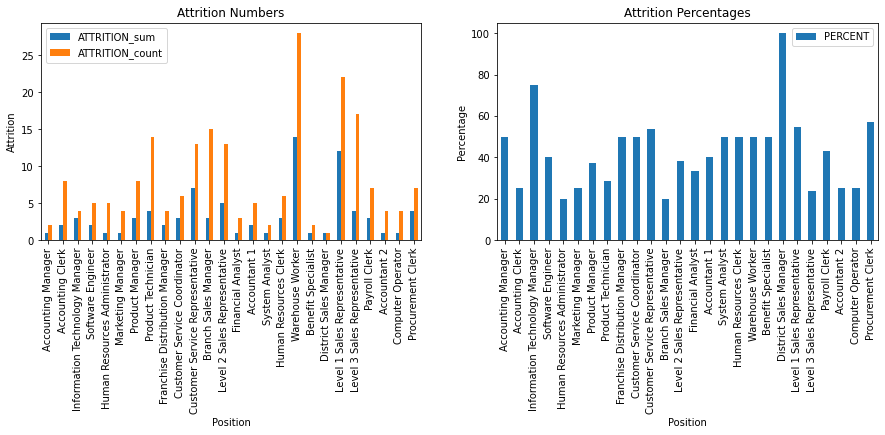

In [13]:
# Separate graphs for 
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(15)

graph2_pd[['POSITION','ATTRITION_sum','ATTRITION_count']].plot.bar(ax=axes[0], xlabel="Position", ylabel="Attrition",
                         title="Attrition Numbers", legend=True)
graph2_pd[['POSITION','PERCENT']].plot.bar(ax=axes[1], xlabel="Position", ylabel="Percentage",
                         title="Attrition Percentages", legend=True)                                                           